Welcome. This notebook can be used to try out the Stable Image Services. This implementation can be used in your production environment if you are developing an application using the API.

New to colab? Just hit the play button on each of the cells and follow instructions.

You will need an account on https://platform.stability.ai/ to use the features.

Have fun and do great things.

In [1]:
#@title Install requirements
from io import BytesIO
import IPython
import json
import os
from PIL import Image
import requests
import time
from google.colab import output

In [2]:
#@title Connect to the Stability API

import getpass
# @markdown To get your API key visit https://platform.stability.ai/account/keys
STABILITY_KEY = getpass.getpass('Enter your API Key')



Enter your API Key··········


In [3]:
#@title Define functions

def send_generation_request(
    host,
    params,
    files = None
):
    headers = {
        "Accept": "image/*",
        "Authorization": f"Bearer {STABILITY_KEY}"
    }

    if files is None:
        files = {}

    # Encode parameters
    image = params.pop("image", None)
    mask = params.pop("mask", None)
    if image is not None and image != '':
        files["image"] = open(image, 'rb')
    if mask is not None and mask != '':
        files["mask"] = open(mask, 'rb')
    if len(files)==0:
        files["none"] = ''

    # Send request
    print(f"Sending REST request to {host}...")
    response = requests.post(
        host,
        headers=headers,
        files=files,
        data=params
    )
    if not response.ok:
        raise Exception(f"HTTP {response.status_code}: {response.text}")

    return response

def send_async_generation_request(
    host,
    params,
    files = None
):
    headers = {
        "Accept": "application/json",
        "Authorization": f"Bearer {STABILITY_KEY}"
    }

    if files is None:
        files = {}

    # Encode parameters
    image = params.pop("image", None)
    mask = params.pop("mask", None)
    if image is not None and image != '':
        files["image"] = open(image, 'rb')
    if mask is not None and mask != '':
        files["mask"] = open(mask, 'rb')
    if len(files)==0:
        files["none"] = ''

    # Send request
    print(f"Sending REST request to {host}...")
    response = requests.post(
        host,
        headers=headers,
        files=files,
        data=params
    )
    if not response.ok:
        raise Exception(f"HTTP {response.status_code}: {response.text}")

    # Process async response
    response_dict = json.loads(response.text)
    generation_id = response_dict.get("id", None)
    assert generation_id is not None, "Expected id in response"

    # Loop until result or timeout
    timeout = int(os.getenv("WORKER_TIMEOUT", 500))
    start = time.time()
    status_code = 202
    while status_code == 202:
        print(f"Polling results at https://api.stability.ai/v2beta/results/{generation_id}")
        response = requests.get(
            f"https://api.stability.ai/v2beta/results/{generation_id}",
            headers={
                **headers,
                "Accept": "*/*"
            },
        )

        if not response.ok:
            raise Exception(f"HTTP {response.status_code}: {response.text}")
        status_code = response.status_code
        time.sleep(10)
        if time.time() - start > timeout:
            raise Exception(f"Timeout after {timeout} seconds")

    return response

# Generate

Stable Image services include:

- Ultra: Our most advanced text to image generation service.

- SD3.5: Generate using Stable Diffusion 3.5 models: SD3.5 Large, SD3.5 Large Turbo, SD3.5 Medium, and SD3.5 Flash. Try the [SD3 notebook](https://colab.research.google.com/github/stability-ai/stability-sdk/blob/main/nbs/SD3_API.ipynb).

- Core: Our primary service for text-to-image generation.

See https://platform.stability.ai/docs/api-reference#tag/Generate

Pricing page: https://platform.stability.ai/pricing

Try these services out in the sections below. Check back in for regular updates.

Feedback welcome.

Sending REST request to https://api.stability.ai/v2beta/stable-image/generate/ultra...
Saved image generated_969449665.jpeg


<IPython.core.display.Javascript object>

Result image:


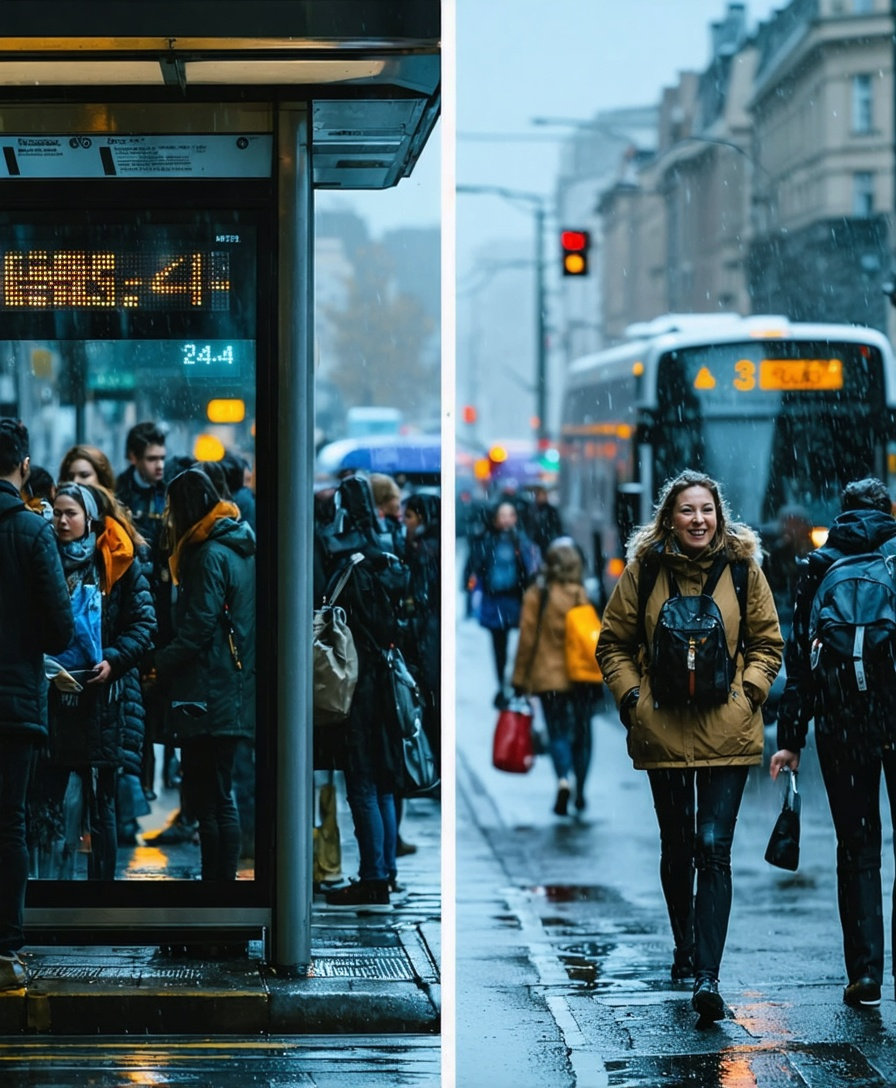

In [10]:
#@title Stable Image Ultra

prompt = "A cinematic split-scene of a busy city bus stop during rush hour. LEFT side: crowded, frustrated passengers waiting in the rain, buses delayed and stuck in traffic, tense atmosphere, gray tones, wet pavement. RIGHT side: the same location transformed — smart bus stop display shows “Bus 24 – arriving in 4 minutes,” passengers relaxed and smiling, warm lighting, cleaner streets, sense of order. Hyper-realistic 8K detail, cinematic lighting, Canon EOS R5, f/2.8, shallow depth of field, dramatic rain reflections, contrast between chaos and clarity." #@param {type:"string"}
negative_prompt = "" #@param {type:"string"}
aspect_ratio = "4:5" #@param ["21:9", "16:9", "3:2", "5:4", "1:1", "4:5", "2:3", "9:16", "9:21"]
seed = 0 #@param {type:"integer"}
style_preset = "None" #@param ["None", "3d-model", "analog-film", "anime", "cinematic", "comic-book", "digital-art", "enhance", "fantasy-art", "isometric", "line-art", "low-poly", "modeling-compound", "neon-punk", "origami", "photographic", "pixel-art", "tile-texture"]
output_format = "jpeg" #@param ["webp", "jpeg", "png"]

host = f"https://api.stability.ai/v2beta/stable-image/generate/ultra"

params = {
    "prompt" : prompt,
    "negative_prompt" : negative_prompt,
    "aspect_ratio" : aspect_ratio,
    "seed" : seed,
    "output_format": output_format
}

if style_preset != "None":
    params["style_preset"] = style_preset

response = send_generation_request(
    host,
    params
)

# Decode response
output_image = response.content
finish_reason = response.headers.get("finish-reason")
seed = response.headers.get("seed")

# Check for NSFW classification
if finish_reason == 'CONTENT_FILTERED':
    raise Warning("Generation failed NSFW classifier")

# Save and display result
generated = f"generated_{seed}.{output_format}"
with open(generated, "wb") as f:
    f.write(output_image)
print(f"Saved image {generated}")

output.no_vertical_scroll()
print("Result image:")
IPython.display.display(Image.open(generated))


Sending REST request to https://api.stability.ai/v2beta/stable-image/generate/core...
Saved image generated_3100953779.jpeg


<IPython.core.display.Javascript object>

Result image:


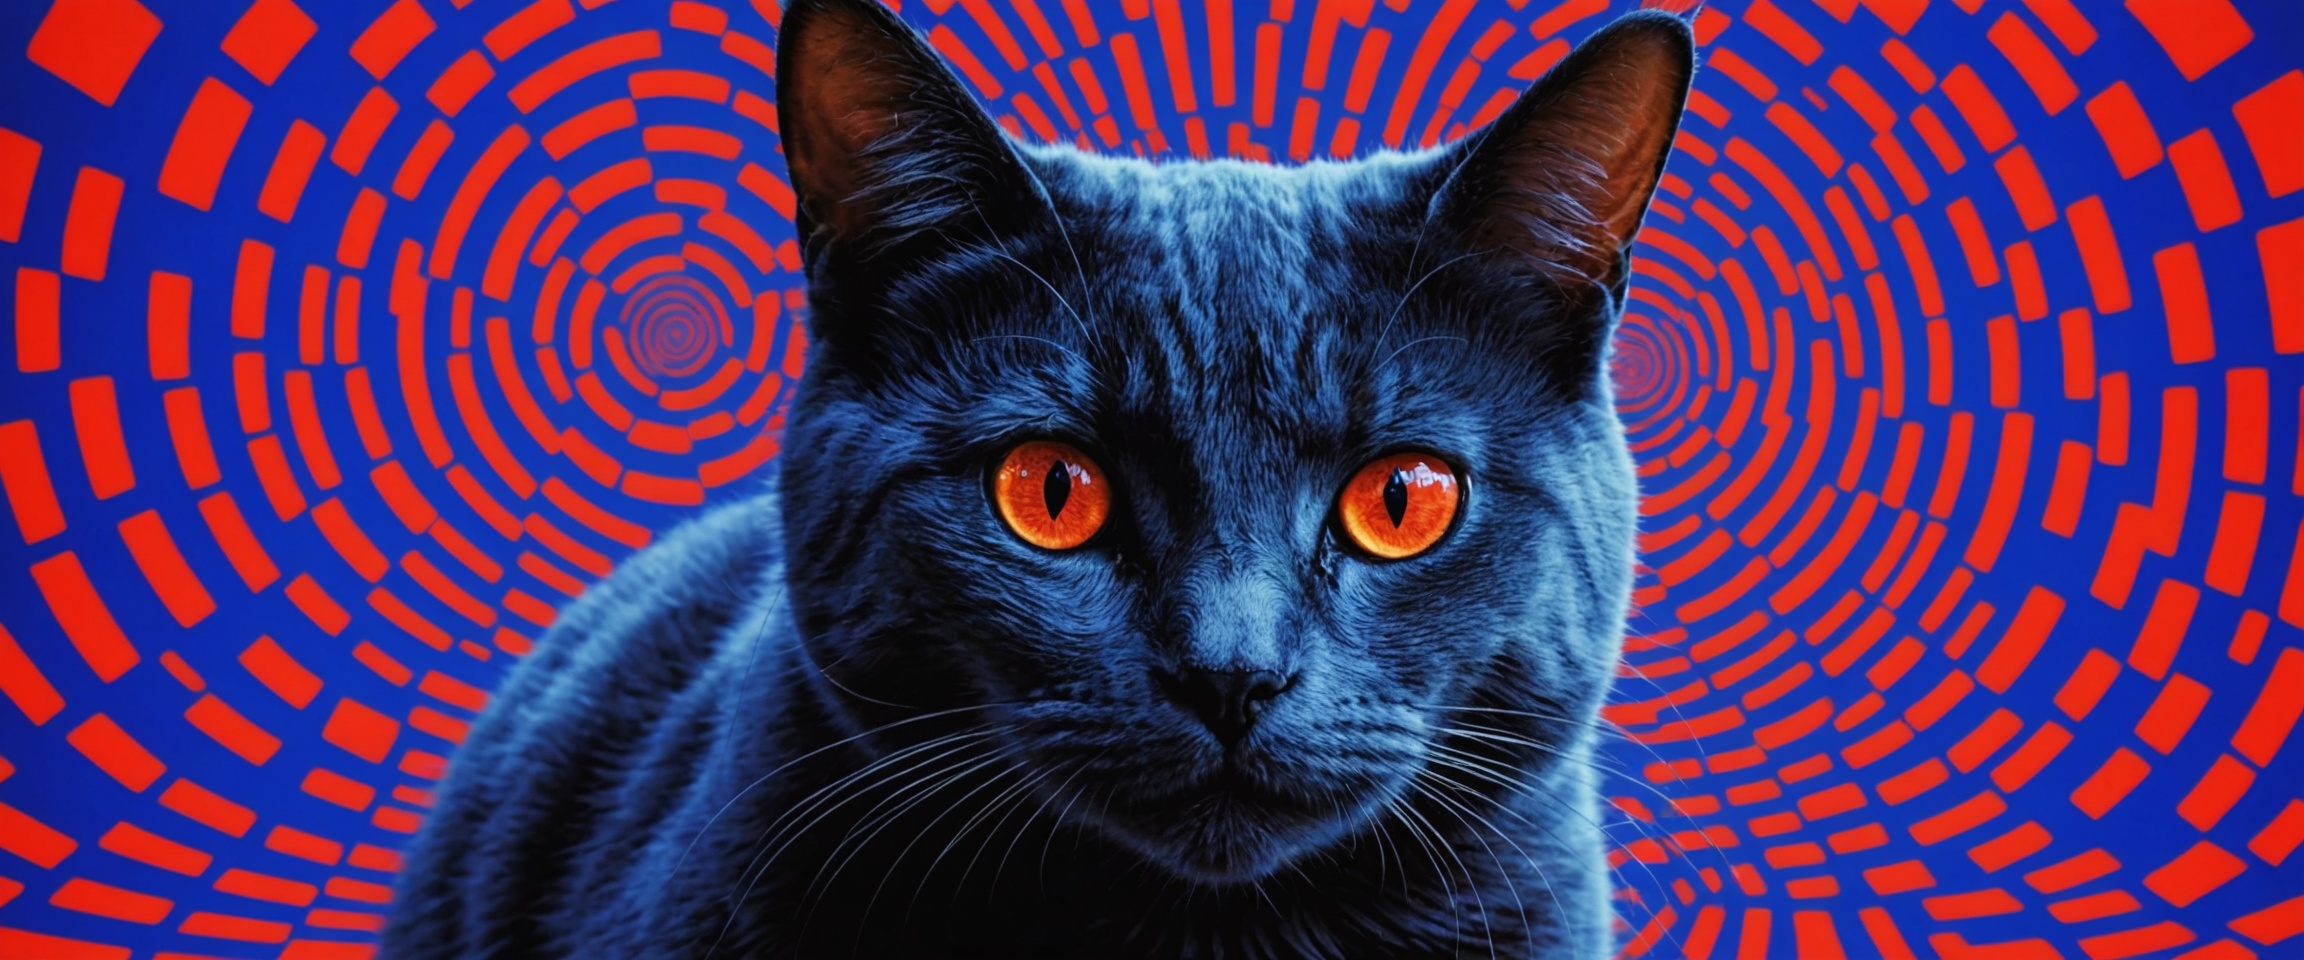

In [5]:
#@title Stable Image Core

prompt = "op art cat illusion red blue chromostereopsis maximum saturation" #@param {type:"string"}
negative_prompt = "" #@param {type:"string"}
aspect_ratio = "21:9" #@param ["21:9", "16:9", "3:2", "5:4", "1:1", "4:5", "2:3", "9:16", "9:21"]
style_preset = "None" #@param ["None", "3d-model", "analog-film", "anime", "cinematic", "comic-book", "digital-art", "enhance", "fantasy-art", "isometric", "line-art", "low-poly", "modeling-compound", "neon-punk", "origami", "photographic", "pixel-art", "tile-texture"]
seed = 0 #@param {type:"integer"}
output_format = "jpeg" #@param ["webp", "jpeg", "png"]

host = f"https://api.stability.ai/v2beta/stable-image/generate/core"

params = {
    "prompt" : prompt,
    "negative_prompt" : negative_prompt,
    "aspect_ratio" : aspect_ratio,
    "seed" : seed,
    "output_format": output_format
}

if style_preset != "None":
    params["style_preset"] = style_preset

response = send_generation_request(
    host,
    params
)

# Decode response
output_image = response.content
finish_reason = response.headers.get("finish-reason")
seed = response.headers.get("seed")

# Check for NSFW classification
if finish_reason == 'CONTENT_FILTERED':
    raise Warning("Generation failed NSFW classifier")

# Save and display result
generated = f"generated_{seed}.{output_format}"
with open(generated, "wb") as f:
    f.write(output_image)
print(f"Saved image {generated}")

output.no_vertical_scroll()
print("Result image:")
IPython.display.display(Image.open(generated))


Sending REST request to https://api.stability.ai/v2beta/stable-image/generate/sd3...
Saved image generated_3984278437.jpeg


<IPython.core.display.Javascript object>

Result image:


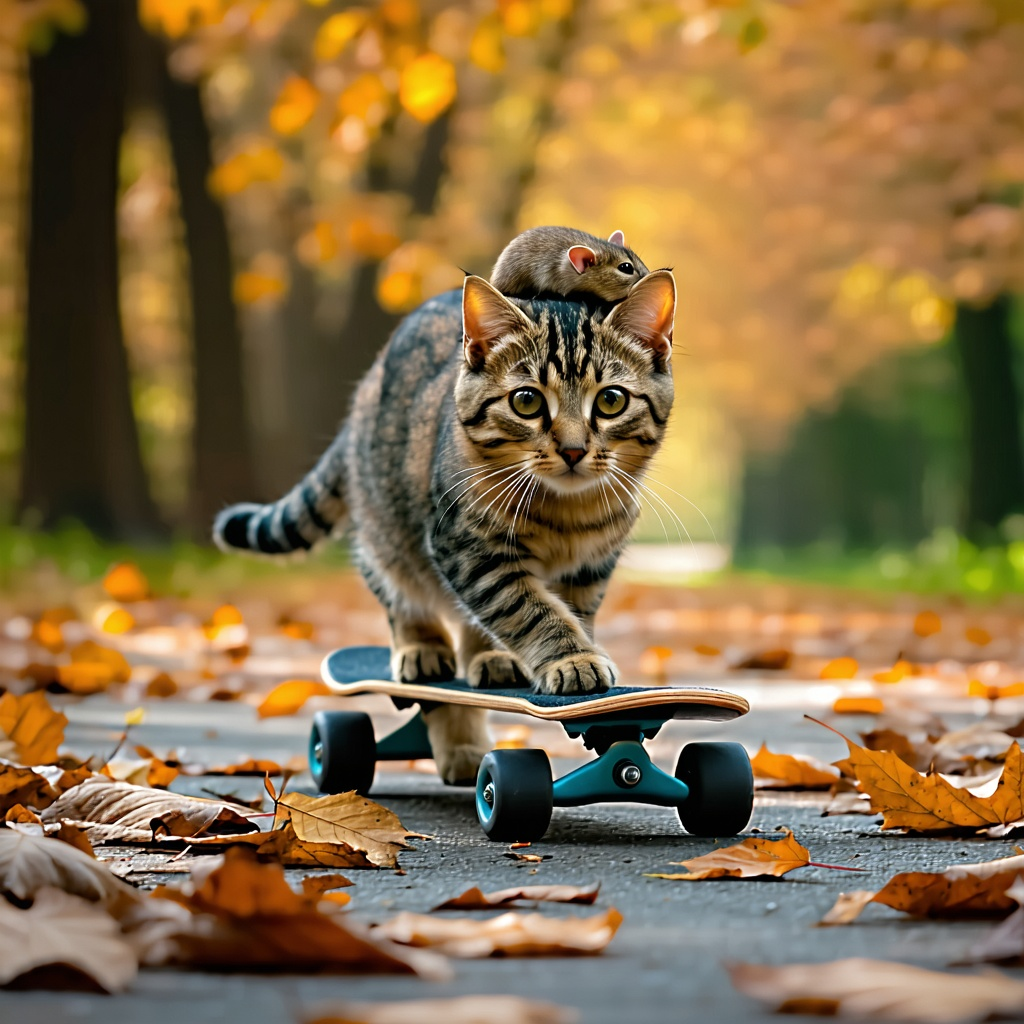

In [6]:
#@title SD3.5

prompt = "cinematic film still, action photo of a cat riding a skateboard through the leaves in autumn. the cat has a mouse friend resting on their head" #@param {type:"string"}
negative_prompt = "" #@param {type:"string"}
aspect_ratio = "1:1" #@param ["21:9", "16:9", "3:2", "5:4", "1:1", "4:5", "2:3", "9:16", "9:21"]
seed = 0 #@param {type:"integer"}
output_format = "jpeg" #@param ["jpeg", "png"]
model = "sd3.5-large" #@param ["sd3.5-large", "sd3.5-large-turbo", "sd3.5-medium", "sd3.5-flash"]
style_preset = "None" #@param ["None","3d-model", "analog-film", "anime", "cinematic", "comic-book", "digital-art", "enhance", "fantasy-art", "isometric", "line-art", "low-poly", "modeling-compound", "neon-punk", "origami", "photographic", "pixel-art", "tile-texture"]

host = f"https://api.stability.ai/v2beta/stable-image/generate/sd3"

params = {
    "prompt" : prompt,
    "negative_prompt" : negative_prompt if model != "sd3.5-large-turbo" and model != "sd3.5-flash" else "",
    "aspect_ratio" : aspect_ratio,
    "seed" : seed,
    "output_format" : output_format,
    "model" : model,
    "mode" : "text-to-image"
}

if style_preset != "None":
    params["style_preset"] = style_preset

response = send_generation_request(
    host,
    params
)

# Decode response
output_image = response.content
finish_reason = response.headers.get("finish-reason")
seed = response.headers.get("seed")

# Check for NSFW classification
if finish_reason == 'CONTENT_FILTERED':
    raise Warning("Generation failed NSFW classifier")

# Save and display result
generated = f"generated_{seed}.{output_format}"
with open(generated, "wb") as f:
    f.write(output_image)
print(f"Saved image {generated}")

output.no_vertical_scroll()
print("Result image:")
IPython.display.display(Image.open(generated))

# Control

Stable Image editing services include four offerings currently in production:

- Sketch: This service offers an ideal solution for design projects that require brainstorming and frequent iterations. It upgrades rough hand-drawn sketches to refined outputs with precise control. For non-sketch images, it allows detailed manipulation of the final appearance by leveraging the contour lines and edges within the image.
- Structure: This service excels in generating images by maintaining the structure of an input image, making it especially valuable for advanced content creation scenarios such as recreating scenes or rendering characters from models.
- Style Guide: This service extracts stylistic elements from an input image (control image) and uses it to guide the creation of an output image based on the prompt. The result is a new image in the same style as the control image.
- Style Transfer: Apply visual styles from a reference image to a target image to maintain consistency across content.

See https://platform.stability.ai/docs/api-reference#tag/Control

Pricing page: https://platform.stability.ai/pricing

Try these services out in the sections below. Check back in for regular updates.

Feedback welcome.

In [7]:
#@title Sketch

#@markdown - Drag and drop image to file folder on left
#@markdown - Right click it and choose Copy path
#@markdown - Paste that path into image field below
#@markdown <br><br>

image = "/content/sketch.jpg" #@param {type:"string"}
prompt = "a creepy wooden cathedral in the forest" #@param {type:"string"}
negative_prompt = "" #@param {type:"string"}
control_strength = 0.7  #@param {type:"slider", min:0, max:1, step:0.05}
seed = 0 #@param {type:"integer"}
output_format = "jpeg" #@param ["webp", "jpeg", "png"]

host = f"https://api.stability.ai/v2beta/stable-image/control/sketch"

params = {
    "control_strength" : control_strength,
    "image" : image,
    "seed" : seed,
    "output_format": output_format,
    "prompt" : prompt,
    "negative_prompt" : negative_prompt,
}

response = send_generation_request(
    host,
    params
)

# Decode response
output_image = response.content
finish_reason = response.headers.get("finish-reason")
seed = response.headers.get("seed")

# Check for NSFW classification
if finish_reason == 'CONTENT_FILTERED':
    raise Warning("Generation failed NSFW classifier")

# Save and display result
filename, _ = os.path.splitext(os.path.basename(image))
edited = f"edited_{filename}_{seed}.{output_format}"
with open(edited, "wb") as f:
    f.write(output_image)
print(f"Saved image {edited}")

output.no_vertical_scroll()
print("Original image:")
IPython.display.display(Image.open(image))
print("Result image:")
IPython.display.display(Image.open(edited))

FileNotFoundError: [Errno 2] No such file or directory: '/content/sketch.jpg'

In [ ]:
#@title Structure

#@markdown - Drag and drop image to file folder on left
#@markdown - Right click it and choose Copy path
#@markdown - Paste that path into image field below
#@markdown <br><br>

image = "/content/toad.jpg" #@param {type:"string"}
prompt = "a victorian toad covered in gems standing in the forest, looking at the viewer" #@param {type:"string"}
negative_prompt = "" #@param {type:"string"}
control_strength = 0.7  #@param {type:"slider", min:0, max:1, step:0.05}
seed = 0 #@param {type:"integer"}
output_format = "jpeg" #@param ["webp", "jpeg", "png"]

host = f"https://api.stability.ai/v2beta/stable-image/control/structure"

params = {
    "control_strength" : control_strength,
    "image" : image,
    "seed" : seed,
    "output_format": output_format,
    "prompt" : prompt,
    "negative_prompt" : negative_prompt,
}

response = send_generation_request(
    host,
    params
)

# Decode response
output_image = response.content
finish_reason = response.headers.get("finish-reason")
seed = response.headers.get("seed")

# Check for NSFW classification
if finish_reason == 'CONTENT_FILTERED':
    raise Warning("Generation failed NSFW classifier")

# Save and display result
filename, _ = os.path.splitext(os.path.basename(image))
edited = f"edited_{filename}_{seed}.{output_format}"
with open(edited, "wb") as f:
    f.write(output_image)
print(f"Saved image {edited}")

output.no_vertical_scroll()
print("Original image:")
IPython.display.display(Image.open(image))
print("Result image:")
IPython.display.display(Image.open(edited))

In [ ]:
#@title Style Guide

#@markdown - Drag and drop image to file folder on left
#@markdown - Right click it and choose Copy path
#@markdown - Paste that path into image field below
#@markdown <br><br>

image = "/content/pastel_landscape.jpg" #@param {type:"string"}
prompt = "cat in the forest" #@param {type:"string"}
negative_prompt = "" #@param {type:"string"}
aspect_ratio = "1:1" #@param ["21:9", "16:9", "3:2", "5:4", "1:1", "4:5", "2:3", "9:16", "9:21"]
fidelity = 0.5  #@param {type:"slider", min:0, max:1, step:0.05}
seed = 0 #@param {type:"integer"}
output_format = "jpeg" #@param ["webp", "jpeg", "png"]

host = f"https://api.stability.ai/v2beta/stable-image/control/style"

params = {
    "fidelity" : fidelity,
    "image" : image,
    "seed" : seed,
    "output_format": output_format,
    "prompt" : prompt,
    "negative_prompt" : negative_prompt,
    "aspect_ratio": aspect_ratio
}

response = send_generation_request(
    host,
    params
)

# Decode response
output_image = response.content
finish_reason = response.headers.get("finish-reason")
seed = response.headers.get("seed")

# Check for NSFW classification
if finish_reason == 'CONTENT_FILTERED':
    raise Warning("Generation failed NSFW classifier")

# Save and display result
filename, _ = os.path.splitext(os.path.basename(image))
edited = f"edited_{filename}_{seed}.{output_format}"
with open(edited, "wb") as f:
    f.write(output_image)
print(f"Saved image {edited}")

output.no_vertical_scroll()
print("Original image:")
IPython.display.display(Image.open(image))
print("Result image:")
IPython.display.display(Image.open(edited))

In [ ]:
#@title Style Transfer

#@markdown - Drag and drop image to file folder on left
#@markdown - Right click it and choose Copy path
#@markdown - Paste that path into image field below
#@markdown <br><br>

image = "/content/cat_statue.jpg" #@param {type:"string"}
style_image = "/content/glowbot.jpg" #@param {type:"string"}
prompt = "" #@param {type:"string"}
negative_prompt = "" #@param {type:"string"}
style_strength = 1.0   #@param {type:"slider", min:0, max:1, step:0.05}
composition_fidelity = 0.9   #@param {type:"slider", min:0, max:1, step:0.05}
change_strength = 0.9   #@param {type:"slider", min:0.1, max:1, step:0.05}
seed = 0 #@param {type:"integer"}
output_format = "jpeg" #@param ["webp", "jpeg", "png"]

host = f"https://api.stability.ai/v2beta/stable-image/control/style-transfer"

params = {
    "change_strength" : change_strength,
    "composition_fidelity" : composition_fidelity,
    "output_format": output_format,
    "prompt" : prompt,
    "negative_prompt" : negative_prompt,
    "seed" : seed,
    "style_strength" : style_strength,
}

files = {}
files["init_image"] = open(image, 'rb')
files["style_image"] = open(style_image, 'rb')

response = send_generation_request(
    host,
    params,
    files
)

# Decode response
output_image = response.content
finish_reason = response.headers.get("finish-reason")
seed = response.headers.get("seed")

# Check for NSFW classification
if finish_reason == 'CONTENT_FILTERED':
    raise Warning("Generation failed NSFW classifier")

# Save and display result
filename, _ = os.path.splitext(os.path.basename(image))
edited = f"edited_{filename}_{seed}.{output_format}"
with open(edited, "wb") as f:
    f.write(output_image)
print(f"Saved image {edited}")

output.no_vertical_scroll()
print("Original image:")
IPython.display.display(Image.open(image))
print("Result image:")
IPython.display.display(Image.open(edited))

# Upscale
Stable Image Upscaling services include:

- Creative Upscaler: This service will transform a low quality, low resolution image into a stunning work of art with intricate details at 9mp resolution - regardless of the input resolution. Provide an input image of poor quality and add a `prompt` that describes the desired output. High `creativity` (up to 0.35) will yield dramatic changes to the image.

- Conservative Upscaler: Upgrade low-res to 4k without reinterpreting the image.

- Fast Upscaler: Simple, low-cost upscaler to increase image resolution by 4, up to 4 megapixels.

See https://platform.stability.ai/docs/api-reference#tag/Upscale

Pricing page: https://platform.stability.ai/pricing

Try the service out in the section below. Check back in for regular updates.


Feedback welcome.


In [ ]:
#@title Creative Upscaler

#@markdown - Drag and drop image to file folder on left
#@markdown - Right click it and choose Copy path
#@markdown - Paste that path into image field below
#@markdown <br><br>

image = "/content/bird.jpg" #@param {type:"string"}
prompt = "This dreamlike digital art captures a vibrant, kaleidoscopic bird in a lush rainforest" #@param {type:"string"}
negative_prompt = "" #@param {type:"string"}
seed = 0 #@param {type:"integer"}
creativity = 0.30 #@param {type:"number"}
output_format = "jpeg" #@param ["webp", "jpeg", "png"]

host = f"https://api.stability.ai/v2beta/stable-image/upscale/creative"

params = {
    "prompt" : prompt,
    "negative_prompt" : negative_prompt,
    "seed" : seed,
    "creativity" : creativity,
    "image" : image,
    "output_format": output_format
}

response = send_async_generation_request(
    host,
    params
)

# Decode response
output_image = response.content
finish_reason = response.headers.get("finish-reason")
seed = response.headers.get("seed")

# Check for NSFW classification
if finish_reason == 'CONTENT_FILTERED':
    raise Warning("Generation failed NSFW classifier")

# Save and display result
filename, _ = os.path.splitext(os.path.basename(image))
upscaled = f"upscaled_{filename}_{seed}.{output_format}"
with open(upscaled, "wb") as f:
    f.write(output_image)
print(f"Saved image {upscaled}")

print("Original image:")
IPython.display.display(Image.open(image))
print("Result image:")
IPython.display.display(Image.open(upscaled))

In [ ]:
#@title Conservative Upscaler

#@markdown - Drag and drop image to file folder on left
#@markdown - Right click it and choose Copy path
#@markdown - Paste that path into image field below
#@markdown <br><br>

image = "/content/chicken.jpg" #@param {type:"string"}
prompt = "photo of a giant chicken in a forest" #@param {type:"string"}
negative_prompt = "" #@param {type:"string"}
seed = 0 #@param {type:"integer"}
creativity = 0.35 #@param {type:"number"}
output_format = "jpeg" #@param ["webp", "jpeg", "png"]

host = f"https://api.stability.ai/v2beta/stable-image/upscale/conservative"

params = {
    "prompt" : prompt,
    "negative_prompt" : negative_prompt,
    "seed" : seed,
    "creativity" : creativity,
    "image" : image,
    "output_format": output_format
}

response = send_generation_request(
    host,
    params
)

# Decode response
output_image = response.content
finish_reason = response.headers.get("finish-reason")
seed = response.headers.get("seed")

# Check for NSFW classification
if finish_reason == 'CONTENT_FILTERED':
    raise Warning("Generation failed NSFW classifier")

# Save and display result
filename, _ = os.path.splitext(os.path.basename(image))
upscaled = f"upscaled_{filename}_{seed}.{output_format}"
with open(upscaled, "wb") as f:
    f.write(output_image)
print(f"Saved image {upscaled}")

print("Original image:")
IPython.display.display(Image.open(image))
print("Result image:")
IPython.display.display(Image.open(upscaled))

In [ ]:
#@title Fast Upscaler

#@markdown - Drag and drop image to file folder on left
#@markdown - Right click it and choose Copy path
#@markdown - Paste that path into image field below
#@markdown <br><br>

image = "/content/cat_statue_512x512.jpg" #@param {type:"string"}
output_format = "jpeg" #@param ["webp", "jpeg", "png"]

host = f"https://api.stability.ai/v2beta/stable-image/upscale/fast"

params = {
    "image" : image,
    "output_format": output_format
}

response = send_generation_request(
    host,
    params
)

# Decode response
output_image = response.content
finish_reason = response.headers.get("finish-reason")
seed = response.headers.get("seed")

# Check for NSFW classification
if finish_reason == 'CONTENT_FILTERED':
    raise Warning("Generation failed NSFW classifier")

# Save and display result
filename, _ = os.path.splitext(os.path.basename(image))
upscaled = f"upscaled_{filename}_{seed}.{output_format}"
with open(upscaled, "wb") as f:
    f.write(output_image)
print(f"Saved image {upscaled}")

print("Original image:")
IPython.display.display(Image.open(image))
print("Result image:")
IPython.display.display(Image.open(upscaled))

# Edit

Stable Image editing services include four offerings currently in production:

- Inpaint: where you specify a `mask` (or use the alpha channel of the `image` parameter). The `prompt` is what will be added to the image in the masked area. Regardless of input resolution, the output will be provided at 4mp.
- Outpaint: Extend an image in any direction.
- Search-and-Recolor: where you specify what you want to recolor in the input image via `select_prompt`. The `prompt` is what will be added to the image in place of the object from the select_prompt. The resolution of the generated image will match the resolution of the input image.
- Search-and-Replace: where you specify what you want to replace in the input image via `search_prompt`. The `prompt` is what will be added to the image in place of the object from the search_prompt. Regardless of input resolution, the output will be provided at 4mp.
- Erase: Remove unwanted objects, such as blemishes on portraits or items on desks, using image masks.
- Remove Background: Removes the background from an image.
- Replace Background and Relight: Swap backgrounds with AI-generated or uploaded images while adjusting lighting to match the subject.

See https://platform.stability.ai/docs/api-reference#tag/Edit

Pricing page: https://platform.stability.ai/pricing

Try these services out in the sections below. Check back in for regular updates.

Feedback welcome.

In [ ]:
#@title Inpaint

#@markdown - Drag and drop image to file folder on left
#@markdown - Right click it and choose Copy path
#@markdown - Paste that path into image field below
#@markdown <br><br>

image = "/content/tux.png" #@param {type:"string"}
mask = "" #@param {type:"string"}
prompt = "artificer of time and space" #@param {type:"string"}
negative_prompt = "" #@param {type:"string"}
seed = 0 #@param {type:"integer"}
output_format = "webp" #@param ["webp", "jpeg", "png"]

host = f"https://api.stability.ai/v2beta/stable-image/edit/inpaint"

params = {
    "image" : image,
    "mask" : mask,
    "negative_prompt" : negative_prompt,
    "seed" : seed,
    "mode": "mask",
    "output_format": output_format,
    "prompt" : prompt
}

response = send_generation_request(
    host,
    params
)

# Decode response
output_image = response.content
finish_reason = response.headers.get("finish-reason")
seed = response.headers.get("seed")

# Check for NSFW classification
if finish_reason == 'CONTENT_FILTERED':
    raise Warning("Generation failed NSFW classifier")

# Save and display result
filename, _ = os.path.splitext(os.path.basename(image))
edited = f"edited_{filename}_{seed}.{output_format}"
with open(edited, "wb") as f:
    f.write(output_image)
print(f"Saved image {edited}")

output.no_vertical_scroll()
print("Original image:")
IPython.display.display(Image.open(image))
print("Result image:")
IPython.display.display(Image.open(edited))

In [ ]:
#@title Outpaint

#@markdown - Drag and drop image to file folder on left
#@markdown - Right click it and choose Copy path
#@markdown - Paste that path into image field below
#@markdown <br><br>

image = "/content/chicken.jpg" #@param {type:"string"}
left = 512 #@param {type:"number"}
right = 512 #@param {type:"number"}
up = 200 #@param {type:"number"}
down = 100 #@param {type:"number"}
prompt = "" #@param {type:"string"}
creativity = 0.5 #@param {type:"number"}
seed = 0 #@param {type:"integer"}
output_format = "webp" #@param ["webp", "jpeg", "png"]

host = f"https://api.stability.ai/v2beta/stable-image/edit/outpaint"

params = {
    "image" : image,
    "left" : left,
    "right" : right,
    "up" : up,
    "down" : down,
    "prompt" : prompt,
    "creativity" : creativity,
    "seed" : seed,
    "output_format": output_format
}

response = send_generation_request(
    host,
    params
)

# Decode response
output_image = response.content
finish_reason = response.headers.get("finish-reason")
seed = response.headers.get("seed")

# Check for NSFW classification
if finish_reason == 'CONTENT_FILTERED':
    raise Warning("Generation failed NSFW classifier")

# Save and display result
filename, _ = os.path.splitext(os.path.basename(image))
edited = f"edited_{filename}_{seed}.{output_format}"
with open(edited, "wb") as f:
    f.write(output_image)
print(f"Saved image {edited}")

output.no_vertical_scroll()
print("Original image:")
IPython.display.display(Image.open(image))
print("Result image:")
IPython.display.display(Image.open(edited))

In [ ]:
#@title Search-and-Recolor

#@markdown - Drag and drop image to file folder on left
#@markdown - Right click it and choose Copy path
#@markdown - Paste that path into image field below
#@markdown <br><br>

image = "/content/chicken.jpg" #@param {type:"string"}
prompt = "green chicken" #@param {type:"string"}
select_prompt = "chicken" #@param {type:"string"}
negative_prompt = "" #@param {type:"string"}
grow_mask = 3 #@param {type:"integer"}
seed = 0 #@param {type:"integer"}
output_format = "webp" #@param ["webp", "jpeg", "png"]

host = f"https://api.stability.ai/v2beta/stable-image/edit/search-and-recolor"

params = {
    "image" : image,
    "grow_mask" : grow_mask,
    "seed" : seed,
    "mode": "search",
    "output_format": output_format,
    "prompt" : prompt,
    "negative_prompt" : negative_prompt,
    "select_prompt": select_prompt,
}

response = send_generation_request(
    host,
    params
)

# Decode response
output_image = response.content
finish_reason = response.headers.get("finish-reason")
seed = response.headers.get("seed")

# Check for NSFW classification
if finish_reason == 'CONTENT_FILTERED':
    raise Warning("Generation failed NSFW classifier")

# Save and display result
filename, _ = os.path.splitext(os.path.basename(image))
edited = f"edited_{filename}_{seed}.{output_format}"
with open(edited, "wb") as f:
    f.write(output_image)
print(f"Saved image {edited}")

output.no_vertical_scroll()
print("Original image:")
IPython.display.display(Image.open(image))
print("Result image:")
IPython.display.display(Image.open(edited))

In [ ]:
#@title Search-and-Replace

#@markdown - Drag and drop image to file folder on left
#@markdown - Right click it and choose Copy path
#@markdown - Paste that path into image field below
#@markdown <br><br>

image = "/content/chicken.png" #@param {type:"string"}
prompt = "a victorian queen standing in the forest, looking at the viewer" #@param {type:"string"}
search_prompt = "chicken" #@param {type:"string"}
negative_prompt = "" #@param {type:"string"}
seed = 0 #@param {type:"integer"}
output_format = "webp" #@param ["webp", "jpeg", "png"]

host = f"https://api.stability.ai/v2beta/stable-image/edit/search-and-replace"

params = {
    "image" : image,
    "seed" : seed,
    "mode": "search",
    "output_format": output_format,
    "prompt" : prompt,
    "negative_prompt" : negative_prompt,
    "search_prompt": search_prompt,
}

response = send_generation_request(
    host,
    params
)

# Decode response
output_image = response.content
finish_reason = response.headers.get("finish-reason")
seed = response.headers.get("seed")

# Check for NSFW classification
if finish_reason == 'CONTENT_FILTERED':
    raise Warning("Generation failed NSFW classifier")

# Save and display result
filename, _ = os.path.splitext(os.path.basename(image))
edited = f"edited_{filename}_{seed}.{output_format}"
with open(edited, "wb") as f:
    f.write(output_image)
print(f"Saved image {edited}")

output.no_vertical_scroll()
print("Original image:")
IPython.display.display(Image.open(image))
print("Result image:")
IPython.display.display(Image.open(edited))

In [ ]:
#@title Erase

#@markdown - Drag and drop image to file folder on left
#@markdown - Right click it and choose Copy path
#@markdown - Paste that path into image/mask field below
#@markdown <br><br>

image = "/content/island.png" #@param {type:"string"}
mask = "" #@param {type:"string"}
seed = 0 #@param {type:"integer"}
output_format = "webp" #@param ["webp", "jpeg", "png"]

host = f"https://api.stability.ai/v2beta/stable-image/edit/erase"

params = {
    "image" : image,
    "mask" : mask,
    "output_format": output_format,
    "seed" : seed,
}

response = send_generation_request(
    host,
    params
)

# Decode response
output_image = response.content
finish_reason = response.headers.get("finish-reason")
seed = response.headers.get("seed")

# Check for NSFW classification
if finish_reason == 'CONTENT_FILTERED':
    raise Warning("Generation failed NSFW classifier")

# Save and display result
filename, _ = os.path.splitext(os.path.basename(image))
edited = f"edited_{filename}_{seed}.{output_format}"
with open(edited, "wb") as f:
    f.write(output_image)
print(f"Saved image {edited}")

output.no_vertical_scroll()
print("Original image:")
IPython.display.display(Image.open(image))
print("Result image:")
IPython.display.display(Image.open(edited))

In [ ]:
#@title Remove Background

#@markdown - Drag and drop image to file folder on left
#@markdown - Right click it and choose Copy path
#@markdown - Paste that path into image field below
#@markdown <br><br>

image = "/content/img.png" #@param {type:"string"}
output_format = "webp" #@param ["webp", "jpeg", "png"]

host = f"https://api.stability.ai/v2beta/stable-image/edit/remove-background"

params = {
    "image" : image,
    "output_format": output_format
}

response = send_generation_request(
    host,
    params
)

# Decode response
output_image = response.content
finish_reason = response.headers.get("finish-reason")
seed = response.headers.get("seed")

# Check for NSFW classification
if finish_reason == 'CONTENT_FILTERED':
    raise Warning("Generation failed NSFW classifier")

# Save and display result
filename, _ = os.path.splitext(os.path.basename(image))
edited = f"edited_{filename}_{seed}.{output_format}"
with open(edited, "wb") as f:
    f.write(output_image)
print(f"Saved image {edited}")

output.no_vertical_scroll()
print("Original image:")
IPython.display.display(Image.open(image))
print("Result image:")
IPython.display.display(Image.open(edited))

In [ ]:
#@title Replace Background and Relight

#@markdown - Drag and drop image to file folder on left
#@markdown - Right click it and choose Copy path
#@markdown - Paste that path into image fields below
#@markdown <br><br>

#@markdown ***
#@markdown ##Required inputs:
subject_image = "/content/obsidian_dragon.jpg" #@param {type:"string"}
#@markdown Use one or both of `background_prompt` string or `background_reference` image
background_prompt = "pastel landscape" #@param {type:"string"}
background_reference = "" #@param {type:"string"}

#@markdown ***
#@markdown ##Optional inputs:

foreground_prompt = "" #@param {type:"string"}
negative_prompt = "" #@param {type:"string"}
preserve_original_subject = 0.6 #@param {type:"slider", min:0, max:1, step:0.05}
original_background_depth =  0.5 #@param {type:"slider", min:0, max:1, step:0.05}
keep_original_background = False #@param {type:"boolean"}

#@markdown Use `light_source_strength` with a `light_reference` image or a `light_source_direction`
light_source_strength = 0.3 #@param {type:"slider", min:0, max:1, step:0.05}
light_reference = "" #@param {type:"string"}
light_source_direction = "none" #@param ["none", "left", "right", "above", "below"]

#@markdown  <br>

seed = 0 #@param {type:"integer"}
output_format = "webp" #@param ["webp", "jpeg", "png"]

host = f"https://api.stability.ai/v2beta/stable-image/edit/replace-background-and-relight"

files = {}
files["subject_image"] = open(subject_image, 'rb')
if background_reference:
    files["background_reference"] = open(background_reference, 'rb')
if light_reference:
    files["light_reference"] = open(light_reference, 'rb')

params = {
    "output_format": output_format,
    "background_prompt": background_prompt,
    "foreground_prompt": foreground_prompt,
    "negative_prompt": negative_prompt,
    "preserve_original_subject": preserve_original_subject,
    "original_background_depth": original_background_depth,
    "keep_original_background": keep_original_background,
    "seed": seed
}
if light_source_direction != "none":
    params["light_source_direction"] = light_source_direction

# light_source_strength is only valid when using light_source_direction or light_reference
if light_source_direction != "none" or light_reference != '':
    params["light_source_strength"] = light_source_strength

response = send_async_generation_request(
    host,
    params,
    files=files
)

# Decode response
output_image = response.content
finish_reason = response.headers.get("finish-reason")
seed = response.headers.get("seed")

# Check for NSFW classification
if finish_reason == 'CONTENT_FILTERED':
    raise Warning("Generation failed NSFW classifier")

# Save and display result
filename, _ = os.path.splitext(os.path.basename(subject_image))
edited = f"edited_{filename}_{seed}.{output_format}"
with open(edited, "wb") as f:
    f.write(output_image)
print(f"Saved image {edited}")

output.no_vertical_scroll()
print("Original image:")
IPython.display.display(Image.open(subject_image))
print("Result image:")
IPython.display.display(Image.open(edited))